In [1]:
# TMT EDA notebook
import os, re, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (11,4)
pd.set_option("display.max_columns", 120)

DATA_DIR = "./data"   # adjust if needed

def mprint(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    


In [2]:
def _norm_name(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s).upper().replace("Ø"," DIA ")
    s = re.sub(r"[-_/]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_sku(material_name: str):
    s = _norm_name(material_name)
    # grade
    g = re.search(r"FE\s*([456]\d{2})\s*(D)?", s)
    grade = None
    if g:
        base = f"FE{g.group(1)}"
        grade = base + ("D" if g.group(2) else "")
    # diameter
    d = re.search(r"(?:DIA\s*)?(\d{1,2})\s*MM", s)
    if not d: d = re.search(r"(?:DIA\s*)?(\d{1,2})(?!\d)\b", s)
    dia = d.group(1) if d else None
    return dia, grade

def load_multisheet_forecast_xlsx(path: str) -> pd.DataFrame:
    """Load an Excel with many SKU sheets and stack them with sheet name as fallback."""
    xls = pd.ExcelFile(path)
    frames = []
    for sheet in xls.sheet_names:
        df = pd.read_excel(path, sheet_name=sheet)
        df["__sheet"] = sheet
        frames.append(df)
    out = pd.concat(frames, ignore_index=True)
    # try to fill Diameter/Grade from columns or from sheet name
    if "Diameter_mm" not in out.columns:
        out["Diameter_mm"] = out["__sheet"].str.extract(r"(\d{1,2})mm", expand=False)
    if "Grade" not in out.columns:
        out["Grade"] = out["__sheet"].str.extract(r"(FE\d{3}D?)", expand=False)
    return out.drop(columns=["__sheet"])


In [3]:
import os
import pandas as pd

DATA_DIR =("C:\Resume Projects\Material Price Forecasting System\data")

# Explicit paths — no pattern guessing
PATH_SYN   = os.path.join(DATA_DIR, "3year_tmt_data.csv")
PATH_CLEAN = os.path.join(DATA_DIR, "cleaned_tmt_data.csv")
PATH_FEAT  = os.path.join(DATA_DIR, "features_tmt.csv")
PATH_FC_XL = os.path.join(DATA_DIR, "forecast_TMTdata.xlsx")

def mprint(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

mprint("Detected files")
print("Synthetic :", PATH_SYN if os.path.exists(PATH_SYN) else "Not found")
print("Cleaned   :", PATH_CLEAN if os.path.exists(PATH_CLEAN) else "Not found")
print("Features  :", PATH_FEAT if os.path.exists(PATH_FEAT) else "Not found")
print("ForecastXL:", PATH_FC_XL if os.path.exists(PATH_FC_XL) else "Not found")

# Example of loading if needed
if os.path.exists(PATH_SYN):
    df_syn = pd.read_csv(PATH_SYN, parse_dates=["Invoice_Date"])
if os.path.exists(PATH_CLEAN):
    df_clean = pd.read_csv(PATH_CLEAN, parse_dates=["Invoice_Date"])
if os.path.exists(PATH_FEAT):
    df_feat = pd.read_csv(PATH_FEAT, parse_dates=["Invoice_Date"])
if os.path.exists(PATH_FC_XL):
    df_fc = pd.ExcelFile(PATH_FC_XL)  # or use pd.read_excel



Detected files
Synthetic : C:\Resume Projects\Material Price Forecasting System\data\3year_tmt_data.csv
Cleaned   : C:\Resume Projects\Material Price Forecasting System\data\cleaned_tmt_data.csv
Features  : C:\Resume Projects\Material Price Forecasting System\data\features_tmt.csv
ForecastXL: C:\Resume Projects\Material Price Forecasting System\data\forecast_TMTdata.xlsx


In [ ]:
dfs = {}

if PATH_SYN and os.path.exists(PATH_SYN):
    dfs["synthetic"] = pd.read_csv(PATH_SYN, parse_dates=["Invoice_Date"])
if PATH_CLEAN and os.path.exists(PATH_CLEAN):
    dfs["cleaned"]   = pd.read_csv(PATH_CLEAN, parse_dates=["Invoice_Date"])
if PATH_FEAT and os.path.exists(PATH_FEAT):
    # features sometimes have many columns
    dfs["features"]  = pd.read_csv(PATH_FEAT, parse_dates=["Invoice_Date"])
if PATH_FC_XL and os.path.exists(PATH_FC_XL):
    dfs["forecast"]  = load_multisheet_forecast_xlsx(PATH_FC_XL)
    # normalise forecast date col name variants
    for c in ["Invoice_Date", "Date", "ds"]:
        if c in dfs["forecast"].columns:
            if c != "Invoice_Date":
                dfs["forecast"] = dfs["forecast"].rename(columns={c:"Invoice_Date"})
            break

for name, df in dfs.items():
    mprint(f"{name} — shape / head")
    print(df.shape)
    display(df.head(3))


In [5]:
dfs = {}

if PATH_SYN and os.path.exists(PATH_SYN):
    dfs["synthetic"] = pd.read_csv(PATH_SYN, parse_dates=["Invoice_Date"])
if PATH_CLEAN and os.path.exists(PATH_CLEAN):
    dfs["cleaned"]   = pd.read_csv(PATH_CLEAN, parse_dates=["Invoice_Date"])
if PATH_FEAT and os.path.exists(PATH_FEAT):
    # features sometimes have many columns
    dfs["features"]  = pd.read_csv(PATH_FEAT, parse_dates=["Invoice_Date"])
if PATH_FC_XL and os.path.exists(PATH_FC_XL):
    dfs["forecast"]  = load_multisheet_forecast_xlsx(PATH_FC_XL)
    # normalise forecast date col name variants
    for c in ["Invoice_Date", "Date", "ds"]:
        if c in dfs["forecast"].columns:
            if c != "Invoice_Date":
                dfs["forecast"] = dfs["forecast"].rename(columns={c:"Invoice_Date"})
            break

for name, df in dfs.items():
    mprint(f"{name} — shape / head")
    print(df.shape)
    display(df.head(3))



synthetic — shape / head
(1000, 7)


,Invoice_Date,Material_Name,Quantity_MT,Total_Invoice_Value,Unit_Price,UOM,Vendor_Name
0,2022-04-04,TMT REBAR FE550D DIA 10mm,20.63,1157961.9,56130.0,MT,Shakti Steel Traders
1,2022-04-04,TMT REBAR FE550D DIA 32mm,32.94,1865556.9,56635.0,MT,Prime TMT Dealers
2,2022-04-05,TMT REBAR FE550 DIA 16mm,13.39,742743.3,55470.0,MT,SteelMax Solutions



cleaned — shape / head
(783, 7)


,Invoice_Date,Material_Name,Quantity_MT,Total_Invoice_Value,Unit_Price,UOM,Vendor_Name
0,2022-05-19,TMT REBAR FE500D DIA 12MM,8.98,659625.9,61750.0,MTS,MS AGARWAL FOUNDRIES PRIVATE LIMITED
1,2022-05-19,TMT REBAR FE500D DIA 20MM,19.94,1464692.7,61750.0,MTS,MS AGARWAL FOUNDRIES PRIVATE LIMITED
2,2022-05-21,TMT REBAR FE500D DIA 10MM,7.98,567338.1,60250.0,MTS,Rawmart Material Solutions Pvt Ltd



features — shape / head
(783, 22)


,Invoice_Date,Material_Name,Quantity_MT,Total_Invoice_Value,Unit_Price,UOM,Vendor_Name,year,month,day,day_of_week,quarter,is_month_start,is_month_end,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,vendor_id,order_qty,log_order_qty
0,2022-05-19,TMT REBAR FE500D DIA 12MM,8.98,659625.9,61750.0,MTS,MS AGARWAL FOUNDRIES PRIVATE LIMITED,2022,5,19,3,2,0,0,NaN,NaN,NaN,NaN,NaN,7,8.98,2.300583
1,2022-05-19,TMT REBAR FE500D DIA 20MM,19.94,1464692.7,61750.0,MTS,MS AGARWAL FOUNDRIES PRIVATE LIMITED,2022,5,19,3,2,0,0,61750.0,NaN,NaN,NaN,NaN,7,19.94,3.041661
2,2022-05-21,TMT REBAR FE500D DIA 10MM,7.98,567338.1,60250.0,MTS,Rawmart Material Solutions Pvt Ltd,2022,5,21,5,2,0,0,61750.0,NaN,NaN,NaN,NaN,12,7.98,2.195000



forecast — shape / head
(420, 4)


,Invoice_Date,Diameter_mm,Grade,Forecasted_Price
0,2025-07-10,10,FE500D,44490.07
1,2025-07-11,10,FE500D,44500.72
2,2025-07-12,10,FE500D,44532.74


In [6]:
for name, df in dfs.items():
    mprint(f"{name} — columns & dtypes")
    display(pd.DataFrame({"dtype": df.dtypes.astype(str)}))

    miss = df.isna().mean().sort_values(ascending=False)
    mprint(f"{name} — missingness (top 10)")
    display(miss.head(10).to_frame("missing_frac"))



synthetic — columns & dtypes


,dtype
Invoice_Date,datetime64[ns]
Material_Name,object
Quantity_MT,float64
Total_Invoice_Value,float64
Unit_Price,float64
UOM,object
Vendor_Name,object



synthetic — missingness (top 10)


,missing_frac
Invoice_Date,0.0
Material_Name,0.0
Quantity_MT,0.0
Total_Invoice_Value,0.0
Unit_Price,0.0
UOM,0.0
Vendor_Name,0.0



cleaned — columns & dtypes


,dtype
Invoice_Date,datetime64[ns]
Material_Name,object
Quantity_MT,float64
Total_Invoice_Value,float64
Unit_Price,float64
UOM,object
Vendor_Name,object



cleaned — missingness (top 10)


,missing_frac
Invoice_Date,0.0
Material_Name,0.0
Quantity_MT,0.0
Total_Invoice_Value,0.0
Unit_Price,0.0
UOM,0.0
Vendor_Name,0.0



features — columns & dtypes


,dtype
Invoice_Date,datetime64[ns]
Material_Name,object
Quantity_MT,float64
Total_Invoice_Value,float64
Unit_Price,float64
UOM,object
Vendor_Name,object
year,int64
month,int64
day,int64



features — missingness (top 10)


,missing_frac
lag_30,0.038314
rolling_mean_30,0.038314
rolling_mean_7,0.008940
lag_7,0.008940
lag_1,0.001277
Invoice_Date,0.000000
UOM,0.000000
Unit_Price,0.000000
Total_Invoice_Value,0.000000
Quantity_MT,0.000000



forecast — columns & dtypes


,dtype
Invoice_Date,datetime64[ns]
Diameter_mm,int64
Grade,object
Forecasted_Price,float64



forecast — missingness (top 10)


,missing_frac
Invoice_Date,0.0
Diameter_mm,0.0
Grade,0.0
Forecasted_Price,0.0


In [7]:
for key in ["synthetic","cleaned","features"]:
    if key in dfs and "Material_Name" in dfs[key].columns:
        df = dfs[key].copy()
        parsed = df["Material_Name"].apply(parse_sku)
        df["Diameter_mm"] = parsed.apply(lambda t: t[0])
        df["Grade"]       = parsed.apply(lambda t: t[1])
        dfs[key] = df

# show unique SKUs seen
for key in ["synthetic","cleaned","features","forecast"]:
    if key in dfs:
        mprint(f"{key} — unique SKUs (first 20)")
        cols = [c for c in ["Diameter_mm","Grade"] if c in dfs[key].columns]
        if cols:
            display(dfs[key][cols].drop_duplicates().head(20))



synthetic — unique SKUs (first 20)


,Diameter_mm,Grade
0,10,FE550D
1,32,FE550D
2,16,FE550D
3,32,FE500D
4,12,FE500D
5,25,FE550D
6,20,FE500D
7,12,FE550D
8,16,FE500D
13,25,FE500D



cleaned — unique SKUs (first 20)


,Diameter_mm,Grade
0,12,FE500D
1,20,FE500D
2,10,FE500D
3,16,FE500D
4,8,FE500D
14,25,FE500D
27,32,FE500D
76,8,FE550D
77,16,FE550D
78,20,FE550D



features — unique SKUs (first 20)


,Diameter_mm,Grade
0,12,FE500D
1,20,FE500D
2,10,FE500D
3,16,FE500D
4,8,FE500D
14,25,FE500D
27,32,FE500D
76,8,FE550D
77,16,FE550D
78,20,FE550D



forecast — unique SKUs (first 20)


,Diameter_mm,Grade
0,10,FE500D
30,10,FE550D
60,12,FE500D
90,12,FE550D
120,16,FE500D
150,16,FE550D
180,20,FE500D
210,20,FE550D
240,25,FE500D
270,25,FE550D


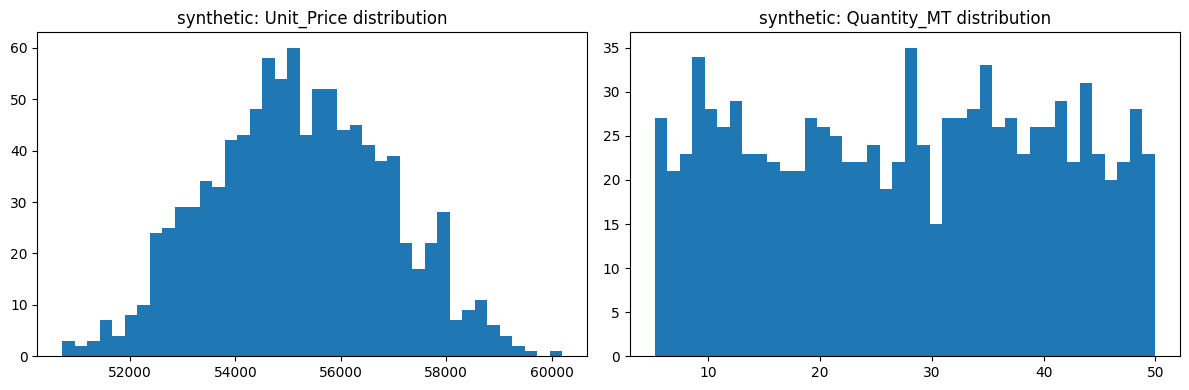

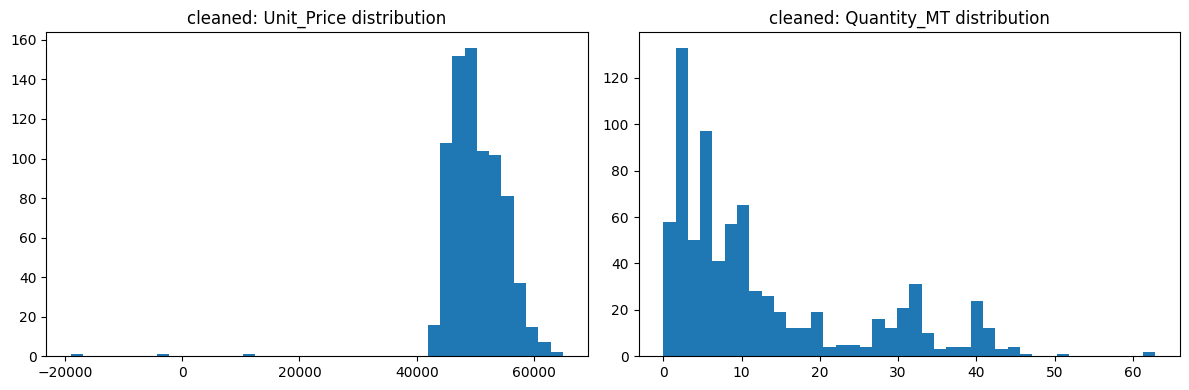

In [19]:
for key in ["synthetic","cleaned"]:
    if key in dfs and {"Unit_Price","Quantity_MT"}.issubset(dfs[key].columns):
        df = dfs[key]
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        ax[0].hist(df["Unit_Price"].dropna(), bins=40)
        ax[0].set_title(f"{key}: Unit_Price distribution")
        ax[1].hist(df["Quantity_MT"].dropna(), bins=40)
        ax[1].set_title(f"{key}: Quantity_MT distribution")
        plt.tight_layout(); plt.show()
        fig.savefig('test.png')


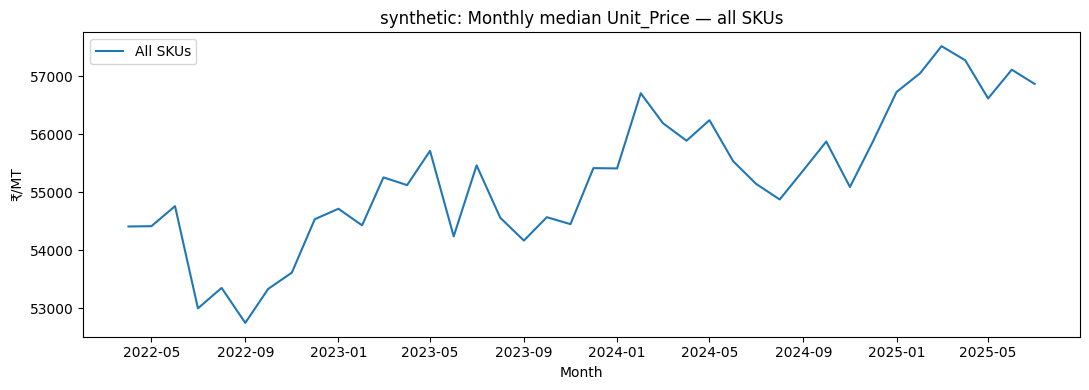

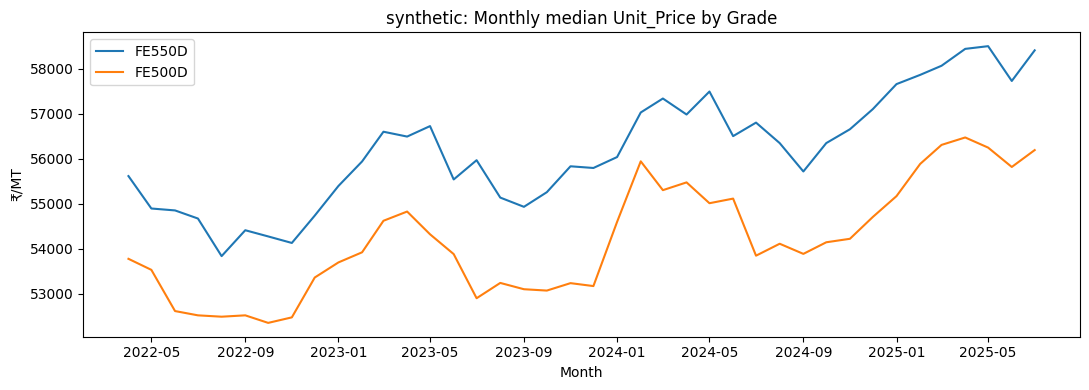

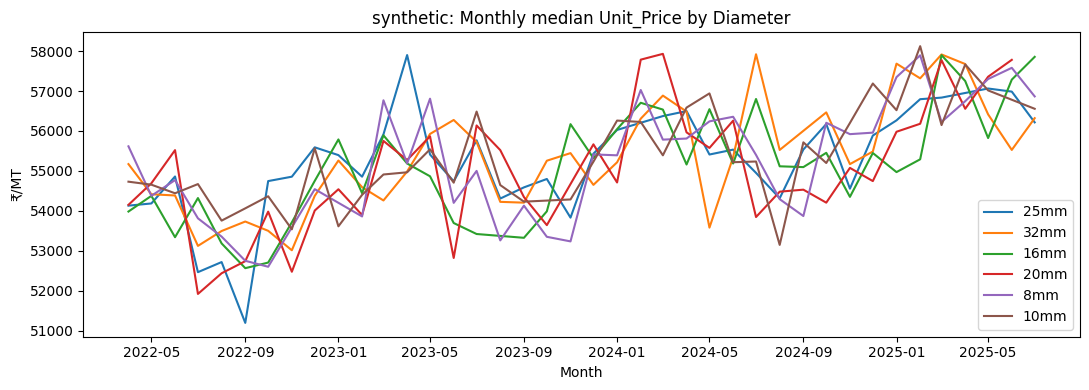

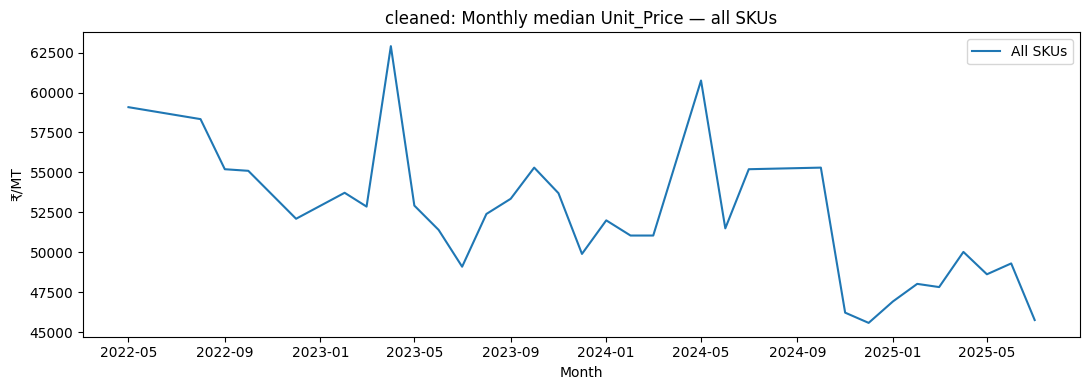

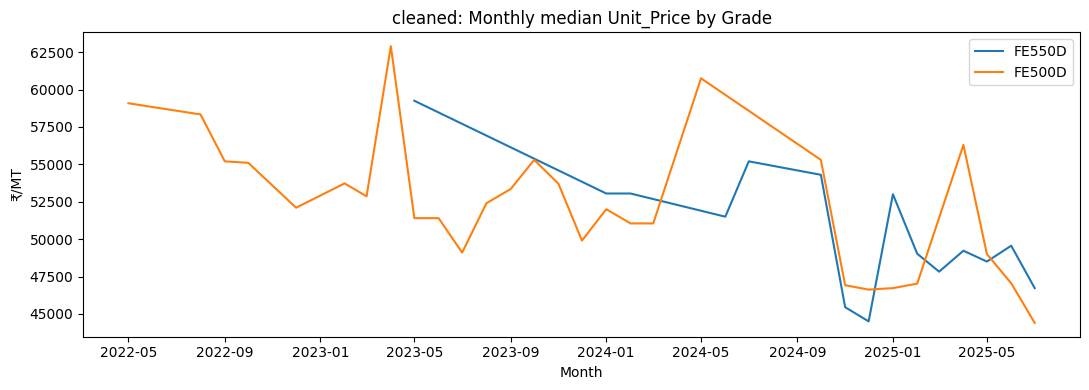

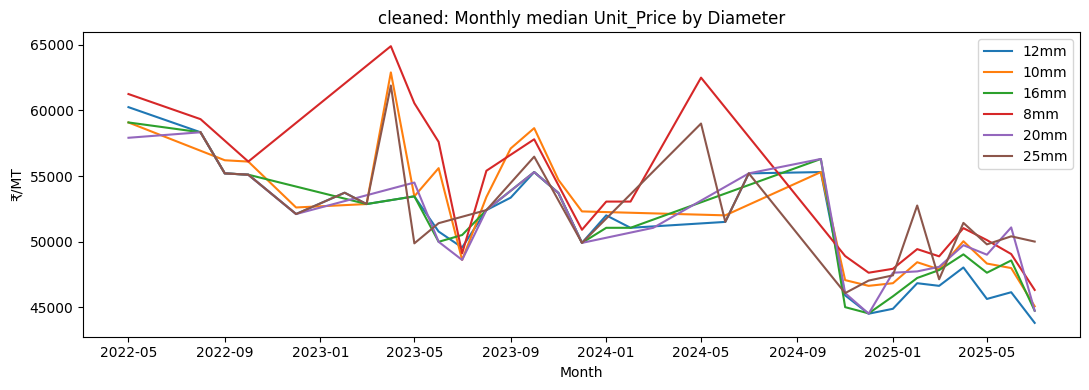

In [23]:
def monthly_curve(df, value_col="Unit_Price", label=""):
    dt = df.copy()
    dt["month"] = dt["Invoice_Date"].dt.to_period("M").dt.to_timestamp()
    m = dt.groupby("month")[value_col].median().reset_index()
    plt.plot(m["month"], m[value_col], label=label)

for key in ["synthetic","cleaned"]:
    if key in dfs:
        df = dfs[key].copy()
        if "Unit_Price" not in df.columns: continue
        plt.figure(figsize=(11,4))
        monthly_curve(df, "Unit_Price", label="All SKUs")
        plt.title(f"{key}: Monthly median Unit_Price — all SKUs")
        plt.xlabel("Month"); plt.ylabel("₹/MT"); plt.legend(); plt.tight_layout(); plt.show()
        fig.savefig('test3.png')

        # by Grade (top 4)
        if "Grade" in df.columns:
            topg = df["Grade"].value_counts().index[:4]
            plt.figure(figsize=(11,4))
            for g in topg:
                monthly_curve(df[df["Grade"]==g], "Unit_Price", label=g)
            plt.title(f"{key}: Monthly median Unit_Price by Grade")
            plt.xlabel("Month"); plt.ylabel("₹/MT"); plt.legend(); plt.tight_layout(); plt.show()
            fig.savefig('test2.png')

        # by Diameter (top 6)
        if "Diameter_mm" in df.columns:
            topd = df["Diameter_mm"].value_counts().index[:6]
            plt.figure(figsize=(11,4))
            for d in topd:
                monthly_curve(df[df["Diameter_mm"]==d], "Unit_Price", label=f"{d}mm")
            plt.title(f"{key}: Monthly median Unit_Price by Diameter")
            plt.xlabel("Month"); plt.ylabel("₹/MT"); plt.legend(); plt.tight_layout(); plt.show()
            fig.savefig('test1.png')


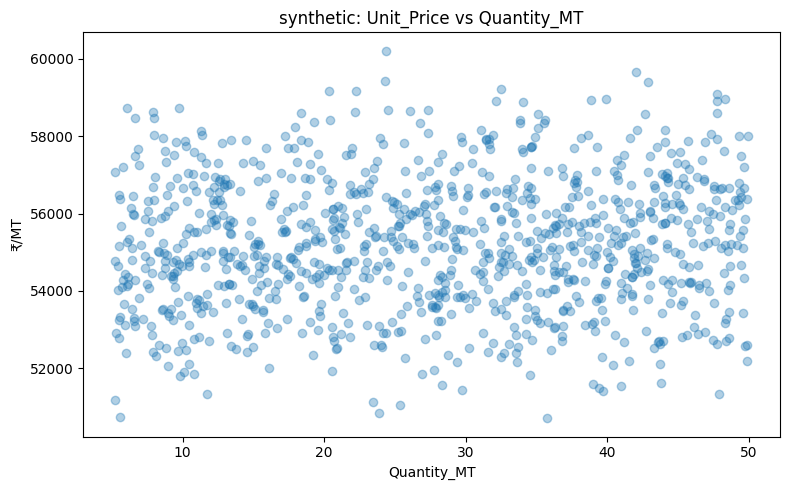

synthetic correlation(Unit_Price, Quantity_MT): 0.065


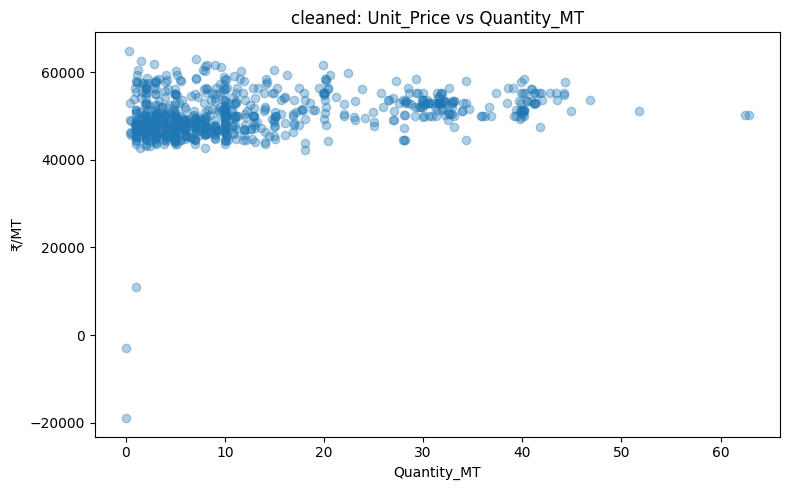

cleaned correlation(Unit_Price, Quantity_MT): 0.277


In [24]:
for key in ["synthetic","cleaned"]:
    if key in dfs and {"Unit_Price","Quantity_MT"}.issubset(dfs[key].columns):
        df = dfs[key].copy()
        plt.figure(figsize=(8,5))
        plt.scatter(df["Quantity_MT"], df["Unit_Price"], alpha=0.35)
        plt.title(f"{key}: Unit_Price vs Quantity_MT")
        plt.xlabel("Quantity_MT"); plt.ylabel("₹/MT")
        plt.tight_layout(); plt.show()

        corr = df[["Unit_Price","Quantity_MT"]].corr().iloc[0,1]
        print(f"{key} correlation(Unit_Price, Quantity_MT): {corr:.3f}")
        fig.savefig('test5.png')


In [15]:
if "features" in dfs:
    feat = dfs["features"]
    num_cols = feat.select_dtypes(include=["number","bool"]).columns
    # a tiny subset of correlations to keep it light
    keep = [c for c in num_cols if c.startswith("lag_") or c.startswith("rolling_mean_")] + ["Unit_Price"]
    keep = list(dict.fromkeys(keep))  # unique, preserve order
    corr = feat[keep].corr().round(2)
    mprint("features — small correlation matrix (lags/rolls vs target)")
    display(corr.tail(10))  # show lower chunk so Unit_Price row likely visible



features — small correlation matrix (lags/rolls vs target)


,lag_1,lag_7,lag_30,rolling_mean_7,rolling_mean_30,Unit_Price
lag_1,1.00,0.33,0.11,0.66,0.46,0.61
lag_7,0.33,1.00,0.12,0.67,0.54,0.35
lag_30,0.11,0.12,1.00,0.21,0.50,0.09
rolling_mean_7,0.66,0.67,0.21,1.00,0.73,0.53
rolling_mean_30,0.46,0.54,0.50,0.73,1.00,0.40
Unit_Price,0.61,0.35,0.09,0.53,0.40,1.00


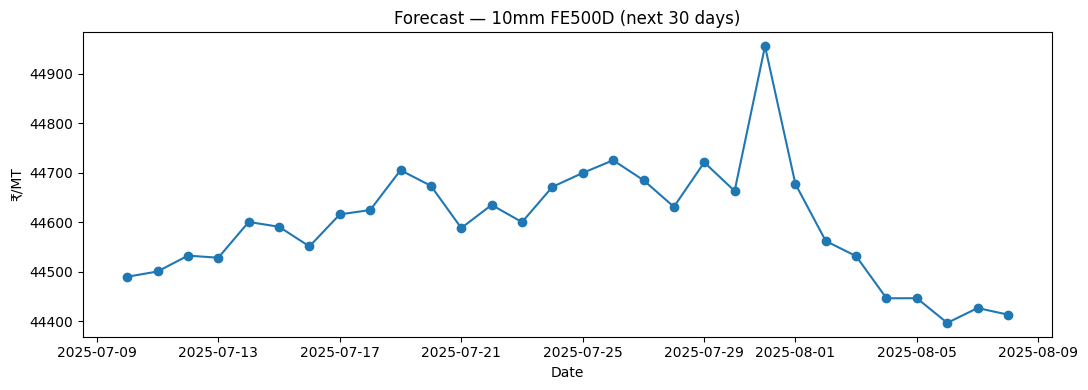

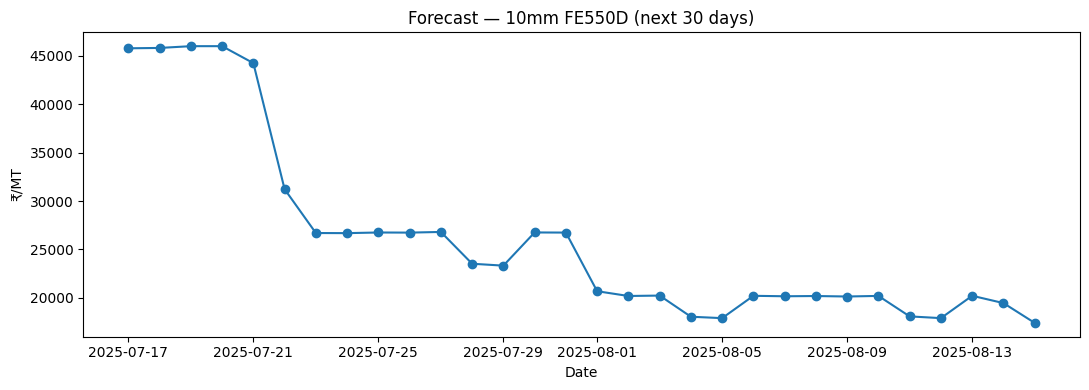

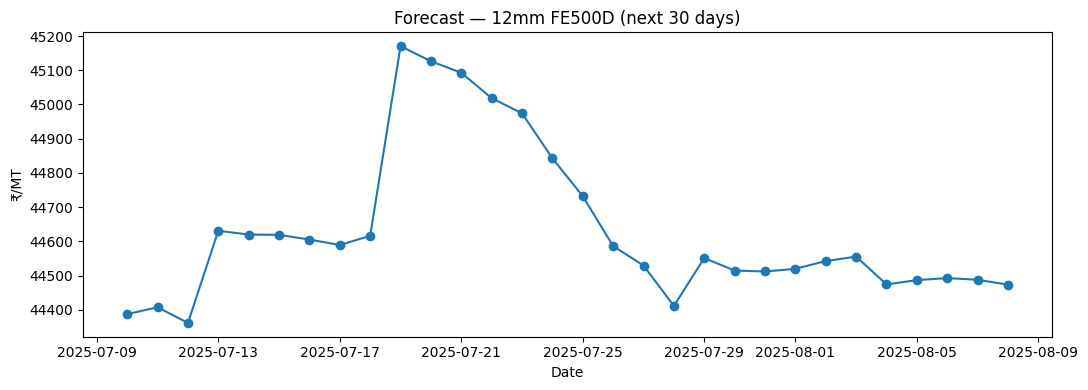

In [25]:
if "forecast" in dfs:
    fc = dfs["forecast"].copy()
    # normalise types
    if "Invoice_Date" in fc.columns:
        fc["Invoice_Date"] = pd.to_datetime(fc["Invoice_Date"])
    # pick a couple SKUs to show
    examples = []
    if {"Diameter_mm","Grade"}.issubset(fc.columns):
        combos = fc[["Diameter_mm","Grade"]].drop_duplicates().head(3).itertuples(index=False)
        examples = list(combos)

    for dia, grade in examples:
        sk = fc[(fc["Diameter_mm"]==dia) & (fc["Grade"]==grade)].sort_values("Invoice_Date")
        y = None
        for cand in ["Forecasted_Price","yhat","price"]:
            if cand in sk.columns:
                y = cand; break
        if y is None or "Invoice_Date" not in sk.columns: 
            continue

        plt.figure(figsize=(11,4))
        plt.plot(sk["Invoice_Date"], sk[y], marker="o")
        plt.title(f"Forecast — {dia}mm {grade} (next 30 days)")
        plt.xlabel("Date"); plt.ylabel("₹/MT"); plt.tight_layout(); plt.show()
        fig.savefig('test6.png')


Showing overlay for SKU: 10mm FE500D


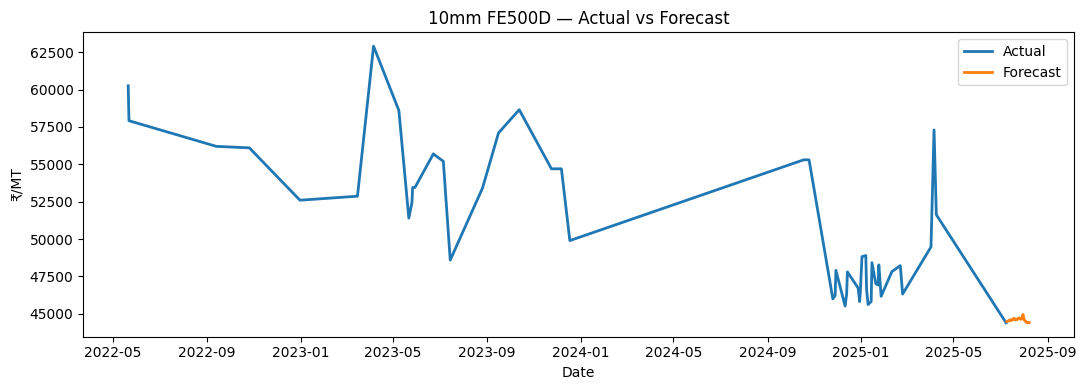

No overlapping dates to compute % deviation.


In [26]:
# === Actual vs Forecast overlay  ===
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _norm_grade(s):
    if pd.isna(s): return pd.NA
    s = str(s).upper()
    m = re.search(r"(FE\ ?[456]\d{2}\ ?D?)", s)
    if not m: return pd.NA
    g = m.group(1).replace(" ", "")
    return g

def _norm_diameter(col):
    """
    Accepts values like '12', '12mm', ' DIA 12 ', 12 (int) etc.
    Returns nullable Int64 with just the number (e.g., 12).
    """
    s = col.astype(str).str.extract(r"(\d{1,2})", expand=False)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def _unify_datecol(df):
    for c in ["Invoice_Date","Date","ds"]:
        if c in df.columns:
            if c != "Invoice_Date":
                df = df.rename(columns={c:"Invoice_Date"})
            df["Invoice_Date"] = pd.to_datetime(df["Invoice_Date"], errors="coerce")
            return df
    raise ValueError("No date-like column found (expected Invoice_Date/Date/ds).")

# ---- guard: need both cleaned and forecast ----
if not {"cleaned","forecast"}.issubset(dfs.keys()):
    print("⚠ Need dfs['cleaned'] and dfs['forecast'] loaded earlier.")
else:
    # ----- build actuals per SKU (daily mean) -----
    act = dfs["cleaned"].copy()
    act = _unify_datecol(act)

    # ensure SKU cols exist (parse from Material_Name if needed)
    if "Diameter_mm" not in act.columns or "Grade" not in act.columns:
        if "Material_Name" not in act.columns:
            raise ValueError("cleaned data is missing Material_Name to parse SKU.")
        # parse from material name
        tmp = act["Material_Name"].astype(str).str.upper()
        # grade
        act["Grade"] = tmp.apply(_norm_grade)
        # diameter (digits)
        act["Diameter_mm"] = _norm_diameter(tmp)
    else:
        # normalize provided SKU columns
        act["Grade"] = act["Grade"].apply(_norm_grade)
        act["Diameter_mm"] = _norm_diameter(act["Diameter_mm"])

    # aggregate actuals to daily mean per SKU
    act_daily = (act
                 .dropna(subset=["Invoice_Date","Unit_Price"])
                 .groupby(["Diameter_mm","Grade","Invoice_Date"], dropna=True)["Unit_Price"]
                 .mean()
                 .reset_index())

    # ----- normalize forecast -----
    fc = dfs["forecast"].copy()
    fc = _unify_datecol(fc)

    # if forecast lacks SKU columns, try to infer from sheet names (should be added earlier)
    if "Diameter_mm" not in fc.columns:
        # best-effort: try from any present label columns
        for c in fc.columns:
            if c.lower().startswith("diameter"):
                fc = fc.rename(columns={c:"Diameter_mm"})
                break
    if "Grade" not in fc.columns:
        for c in fc.columns:
            if c.lower().startswith("grade"):
                fc = fc.rename(columns={c:"Grade"})
                break

    if "Diameter_mm" not in fc.columns or "Grade" not in fc.columns:
        raise ValueError("forecast data missing Diameter_mm/Grade columns; ensure loader stacked them per sheet.")

    # normalize SKU keys
    fc["Grade"] = fc["Grade"].apply(_norm_grade)
    fc["Diameter_mm"] = _norm_diameter(fc["Diameter_mm"])

    # detect forecast value column
    ycol = None
    for cand in ["Forecasted_Price","yhat","price","pred","forecast"]:
        if cand in fc.columns:
            ycol = cand
            break
    if ycol is None:
        raise ValueError("Could not find forecast value column (looked for Forecasted_Price/yhat/price/pred/forecast).")

    # ----- pick a common SKU to show -----
    common = (fc[["Diameter_mm","Grade"]].dropna().drop_duplicates()
                .merge(act_daily[["Diameter_mm","Grade"]].dropna().drop_duplicates(),
                       on=["Diameter_mm","Grade"], how="inner"))
    if common.empty:
        raise ValueError("No overlapping SKU (Diameter_mm, Grade) between forecast and actuals.")

    dia0, grade0 = common.iloc[0]["Diameter_mm"], common.iloc[0]["Grade"]
    print(f"Showing overlay for SKU: {int(dia0)}mm {grade0}")

    a = act_daily[(act_daily["Diameter_mm"]==dia0) & (act_daily["Grade"]==grade0)]
    f = fc[(fc["Diameter_mm"]==dia0) & (fc["Grade"]==grade0)]

    merged = pd.merge(
        a.rename(columns={"Unit_Price":"Actual"}),
        f[["Invoice_Date","Diameter_mm","Grade",ycol]].rename(columns={ycol:"Forecast"}),
        on=["Diameter_mm","Grade","Invoice_Date"],
        how="outer"
    ).sort_values("Invoice_Date")

    # ---- plot overlay ----
    plt.figure(figsize=(11,4))
    if merged["Actual"].notna().any():
        plt.plot(merged["Invoice_Date"], merged["Actual"], label="Actual", linewidth=2)
    if merged["Forecast"].notna().any():
        plt.plot(merged["Invoice_Date"], merged["Forecast"], label="Forecast", linewidth=2)
    plt.title(f"{int(dia0)}mm {grade0} — Actual vs Forecast")
    plt.xlabel("Date"); plt.ylabel("₹/MT"); plt.legend(); plt.tight_layout()
    plt.show()

    # ---- % deviation on overlapping dates ----
    dev = merged.dropna(subset=["Actual","Forecast"]).copy()
    if not dev.empty:
        dev["pct_dev"] = (dev["Forecast"] - dev["Actual"]) / dev["Actual"].abs() * 100
        print("Mean % deviation (overlap):", round(dev["pct_dev"].mean(), 2), "%")
        print("Median % deviation (overlap):", round(dev["pct_dev"].median(), 2), "%")
    else:
        print("No overlapping dates to compute % deviation.")
        fig.savefig('test7.png')
